램용량을 확인해주세요

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


#필요모듈 설치

In [2]:
# 모듈 import
import gc
from IPython.display import clear_output 
!pip install yfinance
!pip install finance-datareader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
!pip install pykrx
from pykrx import stock
from pykrx import bond
from tqdm import tqdm
import dask.dataframe as dd
import FinanceDataReader as fdr
import pickle
pd.set_option('display.max_rows', None) # 데이터프레임 출력 전부다
pd.set_option('display.max_columns', None)
#####################################################
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score,mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
import lightgbm as ltb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
######################################################
from keras.models import Sequential
from keras.layers import Dense
from keras import models, layers  
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from keras.layers import LSTM

clear_output()

# 데이터셋만들기


## 티커가져오기

In [ ]:
tickers = stock.get_market_ticker_list("20221028", market="KOSPI")

In [ ]:
len(tickers)

940

## 함수

In [ ]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

In [ ]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
def stochastic(data, k_window, d_window, window):
    
    # input to function is one column from df
    # containing closing price or whatever value we want to extract K and D from
    
    min_val  = data.rolling(window=window, center=False).min()
    max_val = data.rolling(window=window, center=False).max()
    
    stoch = ( (data - min_val) / (max_val - min_val) ) * 100
    
    K = stoch.rolling(window=k_window, center=False).mean() 
    #K = stoch
    
    D = K.rolling(window=d_window, center=False).mean() 


    return K, D

In [ ]:
def CCI(df):
    df['pt'] = (df['High']+df['Low']+df['Close'])/3
    df['sma'] = df['pt'].rolling(20).mean()
    df['mad']=df['pt'].rolling(20).apply(lambda x: pd.Series(x).mad())
    df['CCI'] = (df['pt'] - df['sma']) / (0.015 * df['mad'])
    return df

In [ ]:
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


def mfi(high, low, close, volume, n=14):
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

In [ ]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## 종목별 OHLCV 데이터 수집

In [ ]:
from tqdm import tqdm
for k in tqdm(range(len(tickers))):
# for k in tqdm(range(1)):
    i=tickers[k]
    df = yf.download(tickers=f'{i}.KS')# 며칠때까지를 학습으로 이용할것인가
    df = df.rename_axis('Date').reset_index()
    # Date 통일화
    df['Date']=df['Date'].astype(str)
    df['plus']=' 00:00:00+09:00'
    df['Date']=df['Date']+df['plus']
    df = df.drop(['plus'], axis=1)    
    
    # # 섹터컬럼 추가
    # a=df_krx.loc[df_krx['Symbol']==i, 'Sector'].values[0]
    # df['Sector']=a
    df['Symbol']=i

    # 이격도 구하기
    df['ma7'] = df['Close'].rolling(7).mean()
    df['ma25'] = df['Close'].rolling(25).mean()
    df['ma99'] = df['Close'].rolling(99).mean()
    df['ma5'] = df['Close'].rolling(5).mean()
    df['ma10'] = df['Close'].rolling(10).mean()
    df['ma20'] = df['Close'].rolling(20).mean()
    df['ma60'] = df['Close'].rolling(60).mean()
    df['ma120'] = df['Close'].rolling(120).mean()
    df['ma50'] = df['Close'].rolling(50).mean()
    df['ma100'] = df['Close'].rolling(100).mean()
    df['ma200'] = df['Close'].rolling(200).mean()
    df['max14'] = df['High'].rolling(14).max()
    df['min14'] = df['Low'].rolling(14).min()
    df['highest_high'] = df['High'].rolling(20).max().shift(-20)
    df['lowest_low'] = df['Low'].rolling(20).min().shift(-20)
    df['after20'] = df['Close'].shift(-20)
    df['highest_high_past'] = df['High'].rolling(20).max()
    df['lowest_low_past'] = df['Low'].rolling(20).min()
    
    
    df['dp7'] = df['Close']/df['ma7']
    df['dp25'] = df['Close']/df['ma25']
    df['dp99'] = df['Close']/df['ma99']
    df['dp5'] = df['Close']/df['ma5']
    df['dp10'] = df['Close']/df['ma10']
    df['dp20'] = df['Close']/df['ma20']
    df['dp60'] = df['Close']/df['ma60']
    df['dp120'] = df['Close']/df['ma120']
    df['dp50'] = df['Close']/df['ma50']
    df['dp100'] = df['Close']/df['ma100']
    df['dp200'] = df['Close']/df['ma200']  

    # 보조지표값 구하기

    df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
    df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
    df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
    df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])
    df['W%R'] = (df['max14']-df['Close'])/((df['max14']-df['min14'])*-100)
    
    df['plus_di'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[0]).rename(columns = {0:'plus_di'})
    df['minus_di'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[1]).rename(columns = {0:'minus_di'})
    df['adx'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[2]).rename(columns = {0:'adx'})  

    df['RSI'] = computeRSI(df['Close'], 14)

    df['K'], df['D'] = stochastic(df['RSI'], 3, 3, 14)

    df= computeMACD(df, 12, 26, 9)

    df = CCI(df)

    # df['MFI'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)

    # 변화량 컬럼 만들기
    lendf=len(df)-2
    day_after=df.shift(-1)
    day_after=day_after.iloc[1:lendf,:]
    yesterday=df.shift(1)
    yesterday=yesterday.iloc[1:lendf,:]
    df=df.iloc[1:lendf,:]

    yesterday = yesterday.reset_index(drop=True)
    day_after = day_after.reset_index(drop=True)
    df = df.reset_index(drop=True)
    
    for sanz in ['Open', 'High','Low','Close']:
        df[f'{sanz}_change']=(df[sanz]-yesterday[sanz])/yesterday[sanz]
    
    df['after20_rate']= (df['after20']-day_after['Open']) / day_after['Open']
    df['lowest_low_rate']= (df['lowest_low']-day_after['Open']) / day_after['Open']
    df['highest_high_rate']= (df['highest_high']-day_after['Open']) / day_after['Open']
    

    div_size=20
    aaa=['plus_di', 'minus_di', 'adx', 'RSI', 'K', 'D', 'MACD', 'MACDsig', 'MACDhist', 'CCI', 'MFI']
    for j in aaa:
        ok=pd.Series([np.nan]*(div_size-1))
        ok2=df.loc[df['High'].rolling(div_size).apply(lambda x: x.idxmax())[(div_size-1):], j]
        seri_concat = pd.concat([ok, ok2], ignore_index=True)
        df[f'High_{j}']=seri_concat

        ok2=df.loc[df['Low'].rolling(div_size).apply(lambda x: x.idxmin())[(div_size-1):], j]
        seri_concat = pd.concat([ok, ok2], ignore_index=True)
        df[f'Low_{j}']=seri_concat

##########################
    df=df.dropna(axis=0) 
#########################

    for sanz in ['Volume','plus_di','minus_di','adx','RSI','K','D','MACD','MACDsig','MACDhist','CCI','MFI','PB','W%R']:
        df[f'{sanz}_change']=(df[sanz]-yesterday[sanz])/yesterday[sanz]
##########################
    df = df.fillna(0)
##########################
    # 히든 다이버전스
    aaa=['plus_di', 'minus_di', 'adx', 'RSI', 'K', 'D', 'MACD', 'MACDsig', 'MACDhist', 'CCI', 'MFI']
    for j in aaa:
        df[f'{j}_updiv'] = 0
        df.loc[  ((df['lowest_low_past']-df['Low']) < 0  ) & ( df[f'Low_{j}'] - df[j] > 0) , f'{j}_updiv']= 1
        
        df[f'{j}_downdiv'] = 0
        df.loc[ ((df['highest_high_past']-df['High']) > 0  ) & ( df[f'High_{j}'] - df[j] < 0) , f'{j}_downdiv']= 1


    # 레이블만들기
    df['tomorrow_pred']=(day_after['Close']-day_after['Open'])/day_after['Open']    

    df['long_short']=0
    df.loc[df['tomorrow_pred']>0, 'long_short']=1   

    df['swing']=0
    df.loc[ (df['highest_high_rate']>=0.1) & (df['lowest_low_rate']>-0.05), 'swing']=1
    





    # 사용할 컬럼 고르기
    df=df.loc[:,['Date','Symbol','dp7','dp25','dp99','dp5','dp10','dp20','dp60','dp120','dp50','dp100','dp200','plus_di','minus_di','adx','RSI','K','D','CCI','MFI','W%R','PB','Open_change','High_change','Low_change','Close_change','Volume_change','plus_di_change', 'minus_di_change', 'adx_change', 'RSI_change','K_change','D_change','MACD_change','MACDsig_change','MACDhist_change','CCI_change','MFI_change','PB_change','W%R_change', 'swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'tomorrow_pred','long_short', 'plus_di_updiv', 'minus_di_updiv', 'adx_updiv', 'RSI_updiv', 'K_updiv', 'D_updiv', 'MACD_updiv', 'MACDsig_updiv', 'MACDhist_updiv', 'CCI_updiv', 'MFI_updiv','plus_di_downdiv', 'minus_di_downdiv', 'adx_downdiv', 'RSI_downdiv', 'K_downdiv', 'D_downdiv', 'MACD_downdiv', 'MACDsig_downdiv', 'MACDhist_downdiv', 'CCI_downdiv', 'MFI_downdiv']]

    if k==0:
        data=df
    else:
        data=pd.concat([data, df])
    
# 빈칸채우기
data = data.reset_index(drop=True)
clear_output()
print('done')

done


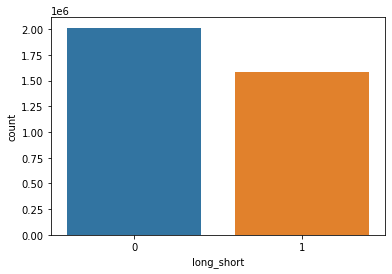

In [ ]:
sns.countplot(x="long_short", data=data)

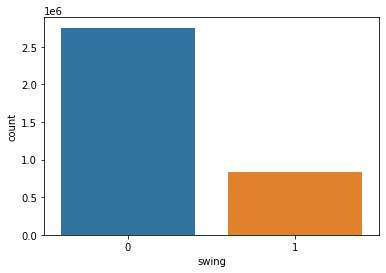

In [ ]:
sns.countplot(x="swing", data=data)

데이터 보내기

In [ ]:
# 데이터 저장
data.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_0.csv')

##종목별 펀디멘탈 데이터 추가

In [ ]:
# data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_0.csv')
# data = dd.read_csv('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_0.csv')
# 데이터 로드
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_0.csv')
data['Date']=data['Date'].astype(str)
gc.collect()

66

In [ ]:
cnt=0
for k in tqdm(range(len(tickers))):    
    i=tickers[k]
    df = stock.get_market_fundamental('10001009','30221022',i)
    df = df.rename_axis('날짜').reset_index()
    df.rename(columns = {'날짜':'Date'},inplace=True)

    # Date 통일화
    df['Date']=df['Date'].astype(str)
    df['plus']=' 00:00:00+09:00'
    df['Date']=df['Date']+df['plus']
    df = df.drop(['plus'], axis=1) 
    df['Symbol']=i
        

    try:
        df['BPS']
    except:
        cnt+=1
        print(i)
    else:
        if k==0:
            data2=pd.merge(df, data)

        else:   
            data3=pd.merge(df, data)
            data2=pd.concat([data2,data3])

print('done')

  4%|▍         | 36/940 [05:42<1:35:47,  6.36s/it]

365550


  7%|▋         | 65/940 [09:23<1:24:06,  5.77s/it]

432320


 12%|█▏        | 111/940 [15:45<1:04:27,  4.67s/it]

400760


 12%|█▏        | 114/940 [16:07<1:16:39,  5.57s/it]

338100


 15%|█▌        | 142/940 [20:34<1:15:48,  5.70s/it]

395400


 36%|███▋      | 343/940 [51:46<54:09,  5.44s/it]  

377190


 37%|███▋      | 349/940 [52:18<37:56,  3.85s/it]

330590


 39%|███▊      | 362/940 [53:59<1:01:57,  6.43s/it]

357430


 39%|███▊      | 364/940 [54:13<59:42,  6.22s/it]  

088980


 39%|███▉      | 365/940 [54:14<44:44,  4.67s/it]

094800


 40%|███▉      | 374/940 [55:24<58:14,  6.17s/it]  

204210


 41%|████      | 382/940 [56:38<1:06:58,  7.20s/it]

396690


 41%|████      | 383/940 [56:39<47:52,  5.16s/it]  

357250


 42%|████▏     | 393/940 [57:51<58:51,  6.46s/it]  

155900


 42%|████▏     | 398/940 [58:35<1:04:26,  7.13s/it]

096300


 57%|█████▋    | 534/940 [1:20:24<56:38,  8.37s/it]  

404990


 57%|█████▋    | 535/940 [1:20:24<40:34,  6.01s/it]

293940


 61%|██████    | 571/940 [1:25:27<34:56,  5.68s/it]

140910


 62%|██████▏   | 580/940 [1:26:34<32:09,  5.36s/it]

900140


 67%|██████▋   | 632/940 [1:34:43<34:37,  6.75s/it]

088260


 68%|██████▊   | 641/940 [1:35:49<27:23,  5.50s/it]

350520


 68%|██████▊   | 642/940 [1:35:50<19:43,  3.97s/it]

334890


 71%|███████▏  | 670/940 [1:39:49<26:23,  5.87s/it]

348950


 76%|███████▋  | 717/940 [1:46:24<15:52,  4.27s/it]

145270


 76%|███████▋  | 718/940 [1:46:24<11:27,  3.10s/it]

417310


 76%|███████▋  | 719/940 [1:46:25<08:30,  2.31s/it]

357120


 83%|████████▎ | 783/940 [1:55:55<17:14,  6.59s/it]

950210


 85%|████████▍ | 795/940 [1:57:25<16:29,  6.82s/it]

152550


 87%|████████▋ | 820/940 [2:01:15<12:58,  6.49s/it]

168490


100%|██████████| 940/940 [2:18:58<00:00,  8.87s/it]

done


In [ ]:
# 데이터 저장
data2 = data2.reset_index(drop=True)
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_1.csv')

## 외국인 매수매도 데이터 추가

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_1.csv')
data['Date']=data['Date'].astype(str)
gc.collect()

44

In [ ]:
cnt=0
for k in tqdm(range(len(tickers))):    
    i=tickers[k]
    try:    
        df1 = stock.get_market_trading_volume_by_date('10001009','30221022',i, on='매수')
        df1 = df1.rename_axis('날짜').reset_index()
        
        # 기타법인+기관
        df1['기관']=df1['기관합계']+df1['기타법인']
        df1 = df1.drop(['기관합계','기타법인'], axis=1)
        
        df1.rename(columns = {'날짜':'Date', '기관':'bank', '개인':'ant', '외국인합계':'foreigner','전체':'buy_all'},inplace=True)

        # Date 통일화
        df1['Date']=df1['Date'].astype(str)
        df1['plus']=' 00:00:00+09:00'
        df1['Date']=df1['Date']+df1['plus']
        df1 = df1.drop(['plus'], axis=1) 
        df1['Symbol']=i
        
        
        
        # 변화량 컬럼 만들기
        lendf=len(df1)-2
        day_after=df1.shift(-1)
        day_after=day_after.iloc[1:lendf,:]
        yesterday=df1.shift(1)
        yesterday=yesterday.iloc[1:lendf,:]
        df1=df1.iloc[1:lendf,:]  

        yesterday = yesterday.reset_index(drop=True)
        day_after = day_after.reset_index(drop=True)
        df1 = df1.reset_index(drop=True)       
        

        for hg in ['bank', 'ant', 'foreigner']:
            df1[f'{hg}_buy_ratio']=df1[f'{hg}']/df1['buy_all']
            df1[f'{hg}_buy_ratio_change']=((df1[f'{hg}']/df1['buy_all'])-(yesterday[f'{hg}']/yesterday['buy_all']))/(yesterday[f'{hg}']/yesterday['buy_all'])
        
        ##########################
        df1 = df1.fillna(0)
        ##########################
        
        # df1 = df1.drop(['all','bank', 'ant', 'foreigner'], axis=1) 
    ###################################################################################################################################################################################################################
        df2 = stock.get_market_trading_volume_by_date('10001009','30221022',i, on='매도')
        df2 = df2.rename_axis('날짜').reset_index()
        
        # 기타법인+기관
        df2['기관']=df2['기관합계']+df2['기타법인']
        df2 = df2.drop(['기관합계','기타법인'], axis=1)
        
        df2.rename(columns = {'날짜':'Date', '기관':'bank', '개인':'ant', '외국인합계':'foreigner','전체':'sell_all'},inplace=True)

        # Date 통일화
        df2['Date']=df2['Date'].astype(str)
        df2['plus']=' 00:00:00+09:00'
        df2['Date']=df2['Date']+df2['plus']
        df2 = df2.drop(['plus'], axis=1) 
        df2['Symbol']=i
        
        
        
        # 변화량 컬럼 만들기
        lendf=len(df2)-2
        day_after=df2.shift(-1)
        day_after=day_after.iloc[1:lendf,:]
        yesterday=df2.shift(1)
        yesterday=yesterday.iloc[1:lendf,:]
        df2=df2.iloc[1:lendf,:]   

        yesterday = yesterday.reset_index(drop=True)
        day_after = day_after.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)       



        for hg in ['bank', 'ant', 'foreigner']:
            df2[f'{hg}_sell_ratio']=df2[f'{hg}']/df2['sell_all']
            df2[f'{hg}_sell_ratio_change']=((df2[f'{hg}']/df2['sell_all'])-(yesterday[f'{hg}']/yesterday['sell_all']))/(yesterday[f'{hg}']/yesterday['sell_all'])

        ##########################
        df2 = df2.fillna(0)
        ##########################


        # df2 = df2.drop(['all','bank', 'ant', 'foreigner'], axis=1) 
    ####################################################################################################################################################################################################################
    except:
        cnt+=1
        print(i)
    
    else:
        df['buy_sell_ratio']=df1['buy_all']/df2['sell_all']
        df1 = df1.drop(['bank', 'ant', 'foreigner'], axis=1) 
        df2 = df2.drop(['bank', 'ant', 'foreigner'], axis=1) 
        df=pd.merge(df1, df2) 
        # df['buy_sell_ratio']=df['buy_all']/df['sell_all']
        df = df.drop(['buy_all', 'sell_all'], axis=1) 
        if k==0:
            # df=pd.merge(df1, df2)
            data2=pd.merge(df, data)
            
        else:
            # df=pd.merge(df1, df2)
            data3=pd.merge(df, data)
            # 합치기
            data2=pd.concat([data2,data3])
    
print('done') 

100%|██████████| 940/940 [1:00:01<00:00,  3.83s/it]

done


In [ ]:
# 데이터 저장
data2 = data2.reset_index(drop=True)
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_2.csv')

In [ ]:
print(len(data2))
data2.isna().sum()

3727239


Date                           0
Symbol                         0
bank_buy_ratio                 0
bank_buy_ratio_change          0
ant_buy_ratio                  0
ant_buy_ratio_change           0
foreigner_buy_ratio            0
foreigner_buy_ratio_change     0
bank_sell_ratio                0
bank_sell_ratio_change         0
ant_sell_ratio                 0
ant_sell_ratio_change          0
foreigner_sell_ratio           0
foreigner_sell_ratio_change    0
BPS                            0
PER                            0
PBR                            0
EPS                            0
DIV                            0
DPS                            0
dp7                            0
dp25                           0
dp99                           0
dp5                            0
dp10                           0
dp20                           0
dp60                           0
dp120                          0
dp50                           0
dp100                          0
dp200     

##외국인 한도소진률 데이터 추가(2.1.1.14 티커별 외국인 보유량 및 외국인 한도소진률)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_2.csv')
data['Date']=data['Date'].astype(str)
gc.collect()
data.drop_duplicates(keep='first', inplace=True)
data = data.reset_index(drop=True)
print(len(data))
print('done')

3727239
done


In [ ]:
cnt=0
for k in tqdm(range(len(tickers))):    
# for k in tqdm(range(2)):    
    i=tickers[k]
    df = stock.get_exhaustion_rates_of_foreign_investment('10001009','30221022',i)
    df = df.rename_axis('날짜').reset_index()
    df.rename(columns = {'날짜':'Date'},inplace=True)

    # Date 통일화
    df['Date']=df['Date'].astype(str)
    df['plus']=' 00:00:00+09:00'
    df['Date']=df['Date']+df['plus']
    df = df.drop(['plus'], axis=1) 
    df['Symbol']=i
        

    try:
        df['상장주식수']
    except:
        cnt+=1
        print(i)
    else:
        df = df.drop(['상장주식수','보유수량','한도수량'], axis=1)
        df.rename(columns = {'지분율':'got', '한도소진률':'limit_gone'},inplace=True)
        if k==0:
            data2=df
        else:
            # 합치기
            data2=pd.concat([data2,df])
    
data2=pd.merge(data, data2)
print('done')

100%|██████████| 940/940 [1:50:16<00:00,  7.04s/it]


done


In [ ]:
print(len(data2))
data2.isna().sum()

3727239


Date                           0
Symbol                         0
bank_buy_ratio                 0
bank_buy_ratio_change          0
ant_buy_ratio                  0
ant_buy_ratio_change           0
foreigner_buy_ratio            0
foreigner_buy_ratio_change     0
bank_sell_ratio                0
bank_sell_ratio_change         0
ant_sell_ratio                 0
ant_sell_ratio_change          0
foreigner_sell_ratio           0
foreigner_sell_ratio_change    0
BPS                            0
PER                            0
PBR                            0
EPS                            0
DIV                            0
DPS                            0
dp7                            0
dp25                           0
dp99                           0
dp5                            0
dp10                           0
dp20                           0
dp60                           0
dp120                          0
dp50                           0
dp100                          0
dp200     

In [ ]:
# 데이터 저장
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_3.csv')

## 공매도 비중(2.1.3.2 종목별 공매도 거래 정보)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_3.csv')
data['Date']=data['Date'].astype(str)
gc.collect()
print('done')

done


In [ ]:
cnt=0
for k in tqdm(range(len(tickers))):    
# for k in tqdm(range(2)):    
    i=tickers[k]
    df = stock.get_shorting_volume_by_date('10001009','30221022',i)
    df = df.rename_axis('날짜').reset_index()
    df.rename(columns = {'날짜':'Date'},inplace=True)

    # Date 통일화
    df['Date']=df['Date'].astype(str)
    df['plus']=' 00:00:00+09:00'
    df['Date']=df['Date']+df['plus']
    df = df.drop(['plus'], axis=1) 
    df['Symbol']=i
        

    try:
        df['공매도']
    except:
        cnt+=1
        print(i)
    else:
        df = df.drop(['공매도','매수'], axis=1)
        df.rename(columns = {'비중':'공매도비중'},inplace=True)
        if k==0:
            data2=df
        else:
            # 합치기
            data2=pd.concat([data2,df])


data2=pd.merge(data, data2)
print('done')

 98%|█████████▊| 917/940 [45:24<00:48,  2.09s/it]

In [ ]:
# 데이터 저장
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_4.csv')

In [ ]:
print(len(data2))
data2.isna().sum()

## 일별채권 수익률 등락폭

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_4.csv')
data['Date']=data['Date'].astype(str)
gc.collect()
print('done')

done


In [ ]:
df1 = bond.get_otc_treasury_yields('20011220','99999999','국고채3년')
df1 = df1.rename_axis('일자').reset_index()

df1.rename(columns = {'일자':'Date', '수익률':'3년국채수익률', '대비':'3년국채수익률대비'},inplace=True)

# Date 통일화
df1['Date']=df1['Date'].astype(str)
df1['plus']=' 00:00:00+09:00'
df1['Date']=df1['Date']+df1['plus']
df1 = df1.drop(['plus'], axis=1)
####################################################################################################
df2 = bond.get_otc_treasury_yields('20011220','99999999','국고채10년')
df2 = df2.rename_axis('일자').reset_index()

df2.rename(columns = {'일자':'Date', '수익률':'10년국채수익률', '대비':'10년국채수익률대비'},inplace=True)

# Date 통일화
df2['Date']=df2['Date'].astype(str)
df2['plus']=' 00:00:00+09:00'
df2['Date']=df2['Date']+df2['plus']
df2 = df2.drop(['plus'], axis=1)
####################################################################################################
df=pd.merge(df1, df2)
data2=pd.merge(data, df)


In [ ]:
# 데이터 저장
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_5.csv')

In [ ]:
print(len(data2))
data2.isna().sum()

In [ ]:
print('꿑!')

In [ ]:
resetindex 시킬것

##지수전용 함수

In [ ]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

In [ ]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
def stochastic(data, k_window, d_window, window):
    
    # input to function is one column from df
    # containing closing price or whatever value we want to extract K and D from
    
    min_val  = data.rolling(window=window, center=False).min()
    max_val = data.rolling(window=window, center=False).max()
    
    stoch = ( (data - min_val) / (max_val - min_val) ) * 100
    
    K = stoch.rolling(window=k_window, center=False).mean() 
    #K = stoch
    
    D = K.rolling(window=d_window, center=False).mean() 


    return K, D

In [ ]:
def CCI(df):
    df['pt'] = (df['High']+df['Low']+df['Close'])/3
    df['sma'] = df['pt'].rolling(20).mean()
    df['mad']=df['pt'].rolling(20).apply(lambda x: pd.Series(x).mad())
    df['CCI'] = (df['pt'] - df['sma']) / (0.015 * df['mad'])
    return df

In [ ]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

## 원달러 환율 데이터

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_5.csv')
data['Date']=data['Date'].astype(str)
gc.collect()
print(len(data))
print('done')

3596344
done


In [ ]:
tker=['USD/KRW']
for k in tqdm(range(len(tker))):
    i=tker[k]
    df = fdr.DataReader(i)
    print(i,len(df))
    df = df.rename_axis('Date').reset_index()
    
    # Date 통일화
    df['Date']=df['Date'].astype(str)
    df['plus']=' 00:00:00+09:00'
    df['Date']=df['Date']+df['plus']
    df = df.drop(['plus','Volume'], axis=1) 
   
    # 이격도 구하기
    df['ma7'] = df['Close'].rolling(7).mean()
    df['ma25'] = df['Close'].rolling(25).mean()
    df['ma99'] = df['Close'].rolling(99).mean()
    df['ma5'] = df['Close'].rolling(5).mean()
    df['ma10'] = df['Close'].rolling(10).mean()
    df['ma20'] = df['Close'].rolling(20).mean()
    df['ma60'] = df['Close'].rolling(60).mean()
    df['ma120'] = df['Close'].rolling(120).mean()
    df['ma50'] = df['Close'].rolling(50).mean()
    df['ma100'] = df['Close'].rolling(100).mean()
    df['ma200'] = df['Close'].rolling(200).mean()
    df['max14'] = df['High'].rolling(14).max()
    df['min14'] = df['Low'].rolling(14).min()
    df['highest_high'] = df['High'].rolling(20).max().shift(-20)
    df['lowest_low'] = df['Low'].rolling(20).min().shift(-20)
    df['after20'] = df['Close'].shift(-20)
    df['highest_high_past'] = df['High'].rolling(20).max()
    df['lowest_low_past'] = df['Low'].rolling(20).min()
    
    
    df['dp7'] = df['Close']/df['ma7']
    df['dp25'] = df['Close']/df['ma25']
    df['dp99'] = df['Close']/df['ma99']
    df['dp5'] = df['Close']/df['ma5']
    df['dp10'] = df['Close']/df['ma10']
    df['dp20'] = df['Close']/df['ma20']
    df['dp60'] = df['Close']/df['ma60']
    df['dp120'] = df['Close']/df['ma120']
    df['dp50'] = df['Close']/df['ma50']
    df['dp100'] = df['Close']/df['ma100']
    df['dp200'] = df['Close']/df['ma200']  

    # 보조지표값 구하기

    df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
    df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
    df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
    df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])
    df['W%R'] = (df['max14']-df['Close'])/((df['max14']-df['min14'])*-100)
    
    df['plus_di'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[0]).rename(columns = {0:'plus_di'})
    df['minus_di'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[1]).rename(columns = {0:'minus_di'})
    df['adx'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[2]).rename(columns = {0:'adx'})  

    df['RSI'] = computeRSI(df['Close'], 14)

    df['K'], df['D'] = stochastic(df['RSI'], 3, 3, 14)

    df= computeMACD(df, 12, 26, 9)

    df = CCI(df)

    # df['MFI'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)

    # 변화량 컬럼 만들기
    lendf=len(df)-2
    day_after=df.shift(-1)
    day_after=day_after.iloc[1:lendf,:]
    yesterday=df.shift(1)
    yesterday=yesterday.iloc[1:lendf,:]
    df=df.iloc[1:lendf,:]

    yesterday = yesterday.reset_index(drop=True)
    day_after = day_after.reset_index(drop=True)
    df = df.reset_index(drop=True)
    
    for sanz in ['Open', 'High','Low','Close']:
        df[f'{sanz}_change']=(df[sanz]-yesterday[sanz])/yesterday[sanz]
    
    df['after20_rate']= (df['after20']-day_after['Open']) / day_after['Open']
    df['lowest_low_rate']= (df['lowest_low']-day_after['Open']) / day_after['Open']
    df['highest_high_rate']= (df['highest_high']-day_after['Open']) / day_after['Open']
    

    div_size=20
    aaa=['plus_di', 'minus_di', 'adx', 'RSI', 'K', 'D', 'MACD', 'MACDsig', 'MACDhist', 'CCI']
    for j in aaa:
        ok=pd.Series([np.nan]*(div_size-1))
        ok2=df.loc[df['High'].rolling(div_size).apply(lambda x: x.idxmax())[(div_size-1):], j]
        seri_concat = pd.concat([ok, ok2], ignore_index=True)
        df[f'High_{j}']=seri_concat

        ok2=df.loc[df['Low'].rolling(div_size).apply(lambda x: x.idxmin())[(div_size-1):], j]
        seri_concat = pd.concat([ok, ok2], ignore_index=True)
        df[f'Low_{j}']=seri_concat

##########################
    df=df.dropna(axis=0) 
#########################

    for sanz in ['plus_di','minus_di','adx','RSI','K','D','MACD','MACDsig','MACDhist','CCI','PB','W%R']:
        df[f'{sanz}_change']=(df[sanz]-yesterday[sanz])/yesterday[sanz]
##########################
    df = df.fillna(0)
##########################
    # 히든 다이버전스
    aaa=['plus_di', 'minus_di', 'adx', 'RSI', 'K', 'D', 'MACD', 'MACDsig', 'MACDhist', 'CCI']
    for j in aaa:
        df[f'{j}_updiv'] = 0
        df.loc[  ((df['lowest_low_past']-df['Low']) < 0  ) & ( df[f'Low_{j}'] - df[j] > 0) , f'{j}_updiv']= 1
        
        df[f'{j}_downdiv'] = 0
        df.loc[ ((df['highest_high_past']-df['High']) > 0  ) & ( df[f'High_{j}'] - df[j] < 0) , f'{j}_downdiv']= 1


    # 레이블만들기
    df['tomorrow_pred']=(day_after['Close']-day_after['Open'])/day_after['Open']    

    df['long_short']=0
    df.loc[df['tomorrow_pred']>0, 'long_short']=1   

    df['swing']=0
    df.loc[ (df['highest_high_rate']>=0.1) & (df['lowest_low_rate']>-0.05), 'swing']=1  
    
    # 사용할것 pick 
    df=df.loc[:,['Date','dp7','dp25','dp99','dp5','dp10','dp20','dp60','dp120','dp50','dp100','dp200','plus_di','minus_di','adx','RSI','K','D','CCI','W%R','PB','Open_change','High_change','Low_change','Close_change','plus_di_change', 'minus_di_change', 'adx_change', 'RSI_change','K_change','D_change','MACD_change','MACDsig_change','MACDhist_change','CCI_change','PB_change','W%R_change','plus_di_updiv', 'minus_di_updiv', 'adx_updiv', 'RSI_updiv', 'K_updiv', 'D_updiv', 'MACD_updiv', 'MACDsig_updiv', 'MACDhist_updiv', 'CCI_updiv','plus_di_downdiv', 'minus_di_downdiv', 'adx_downdiv', 'RSI_downdiv', 'K_downdiv', 'D_downdiv', 'MACD_downdiv', 'MACDsig_downdiv', 'MACDhist_downdiv', 'CCI_downdiv']]
    col=['dp7','dp25','dp99','dp5','dp10','dp20','dp60','dp120','dp50','dp100','dp200','plus_di','minus_di','adx','RSI','K','D','CCI','W%R','PB','Open_change','High_change','Low_change','Close_change','plus_di_change', 'minus_di_change', 'adx_change', 'RSI_change','K_change','D_change','MACD_change','MACDsig_change','MACDhist_change','CCI_change','PB_change','W%R_change','plus_di_updiv', 'minus_di_updiv', 'adx_updiv', 'RSI_updiv', 'K_updiv', 'D_updiv', 'MACD_updiv', 'MACDsig_updiv', 'MACDhist_updiv', 'CCI_updiv','plus_di_downdiv', 'minus_di_downdiv', 'adx_downdiv', 'RSI_downdiv', 'K_downdiv', 'D_downdiv', 'MACD_downdiv', 'MACDsig_downdiv', 'MACDhist_downdiv', 'CCI_downdiv']
    cool=[]
    for hgz in col:
        cool.append(f'{i}_'+hgz)
    
    df.columns = ['Date']+cool


    if k==0:
        data2=df
    else:
        # 합치기
        data2=pd.merge(df, data2)
    gc.collect()


# data2=pd.merge(data, data2)
# gc.collect()
# print('done')

In [ ]:
df.isna().sum()

Date                    0
Open                   31
High                   31
Low                    31
Close                  31
Adj Close              31
ma7                   126
ma25                  400
ma99                 1231
ma5                    94
ma10                  174
ma20                  330
ma60                  833
ma120                1420
ma50                  718
ma100                1240
ma200                2140
max14                 238
min14                 238
highest_high          330
lowest_low            330
after20                49
highest_high_past     330
lowest_low_past       330
dp7                   126
dp25                  400
dp99                 1231
dp5                    94
dp10                  174
dp20                  330
dp60                  833
dp120                1420
dp50                  718
dp100                1240
dp200                2140
stddev                330
upper                 330
lower                 330
PB          

In [ ]:
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_6.csv')

##섹터별 일일변화량 구현/원유 컬럼 추가/S&P 500 지수 추가/코스피 지수 데이터 추가

In [ ]:
# data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_6.csv')
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_5.csv')
data['Date']=data['Date'].astype(str)
gc.collect()
print(len(data))
print('done')

3398905
done


In [ ]:
# # 결측값 제거
# data = data.drop(['bank_buy_ratio_change','ant_buy_ratio_change', 'foreigner_buy_ratio_change', 'bank_sell_ratio_change', 'ant_sell_ratio_change', 'foreigner_sell_ratio_change'], axis=1)
# data=data.dropna(axis=0)
# print(len(data))
# # 중복행 없음

In [ ]:
tker=['^KS11', '^GSPC', 'CL=F']
for k in tqdm(range(len(tker))):
    i=tker[k]
    df = yf.download(tickers= i)
    print(i,len(df))
    df = df.rename_axis('Date').reset_index()
    
    # Date 통일화
    df['Date']=df['Date'].astype(str)
    df['plus']=' 00:00:00+09:00'
    df['Date']=df['Date']+df['plus']
    df = df.drop(['plus'], axis=1) 
   
    # 이격도 구하기
    df['ma7'] = df['Close'].rolling(7).mean()
    df['ma25'] = df['Close'].rolling(25).mean()
    df['ma99'] = df['Close'].rolling(99).mean()
    df['ma5'] = df['Close'].rolling(5).mean()
    df['ma10'] = df['Close'].rolling(10).mean()
    df['ma20'] = df['Close'].rolling(20).mean()
    df['ma60'] = df['Close'].rolling(60).mean()
    df['ma120'] = df['Close'].rolling(120).mean()
    df['ma50'] = df['Close'].rolling(50).mean()
    df['ma100'] = df['Close'].rolling(100).mean()
    df['ma200'] = df['Close'].rolling(200).mean()
    df['max14'] = df['High'].rolling(14).max()
    df['min14'] = df['Low'].rolling(14).min()
    df['highest_high'] = df['High'].rolling(20).max().shift(-20)
    df['lowest_low'] = df['Low'].rolling(20).min().shift(-20)
    df['after20'] = df['Close'].shift(-20)
    df['highest_high_past'] = df['High'].rolling(20).max()
    df['lowest_low_past'] = df['Low'].rolling(20).min()
    
    
    df['dp7'] = df['Close']/df['ma7']
    df['dp25'] = df['Close']/df['ma25']
    df['dp99'] = df['Close']/df['ma99']
    df['dp5'] = df['Close']/df['ma5']
    df['dp10'] = df['Close']/df['ma10']
    df['dp20'] = df['Close']/df['ma20']
    df['dp60'] = df['Close']/df['ma60']
    df['dp120'] = df['Close']/df['ma120']
    df['dp50'] = df['Close']/df['ma50']
    df['dp100'] = df['Close']/df['ma100']
    df['dp200'] = df['Close']/df['ma200']  

    # 보조지표값 구하기

    df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
    df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
    df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
    df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])
    df['W%R'] = (df['max14']-df['Close'])/((df['max14']-df['min14'])*-100)
    
    df['plus_di'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[0]).rename(columns = {0:'plus_di'})
    df['minus_di'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[1]).rename(columns = {0:'minus_di'})
    df['adx'] = pd.DataFrame(get_adx(df['High'], df['Low'], df['Close'], 14)[2]).rename(columns = {0:'adx'})  

    df['RSI'] = computeRSI(df['Close'], 14)

    df['K'], df['D'] = stochastic(df['RSI'], 3, 3, 14)

    df= computeMACD(df, 12, 26, 9)

    df = CCI(df)

    df['MFI'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)

    # 변화량 컬럼 만들기
    lendf=len(df)-2
    day_after=df.shift(-1)
    day_after=day_after.iloc[1:lendf,:]
    yesterday=df.shift(1)
    yesterday=yesterday.iloc[1:lendf,:]
    df=df.iloc[1:lendf,:]

    yesterday = yesterday.reset_index(drop=True)
    day_after = day_after.reset_index(drop=True)
    df = df.reset_index(drop=True)
    
    for sanz in ['Open', 'High','Low','Close']:
        df[f'{sanz}_change']=(df[sanz]-yesterday[sanz])/yesterday[sanz]
    
    df['after20_rate']= (df['after20']-day_after['Open']) / day_after['Open']
    df['lowest_low_rate']= (df['lowest_low']-day_after['Open']) / day_after['Open']
    df['highest_high_rate']= (df['highest_high']-day_after['Open']) / day_after['Open']
    

    div_size=20
    aaa=['plus_di', 'minus_di', 'adx', 'RSI', 'K', 'D', 'MACD', 'MACDsig', 'MACDhist', 'CCI', 'MFI']
    for j in aaa:
        ok=pd.Series([np.nan]*(div_size-1))
        ok2=df.loc[df['High'].rolling(div_size).apply(lambda x: x.idxmax())[(div_size-1):], j]
        seri_concat = pd.concat([ok, ok2], ignore_index=True)
        df[f'High_{j}']=seri_concat

        ok2=df.loc[df['Low'].rolling(div_size).apply(lambda x: x.idxmin())[(div_size-1):], j]
        seri_concat = pd.concat([ok, ok2], ignore_index=True)
        df[f'Low_{j}']=seri_concat

##########################
    df=df.dropna(axis=0) 
#########################

    for sanz in ['Volume','plus_di','minus_di','adx','RSI','K','D','MACD','MACDsig','MACDhist','CCI','MFI','PB','W%R']:
        df[f'{sanz}_change']=(df[sanz]-yesterday[sanz])/yesterday[sanz]
##########################
    df = df.fillna(0)
##########################
    # 히든 다이버전스
    aaa=['plus_di', 'minus_di', 'adx', 'RSI', 'K', 'D', 'MACD', 'MACDsig', 'MACDhist', 'CCI', 'MFI']
    for j in aaa:
        df[f'{j}_updiv'] = 0
        df.loc[  ((df['lowest_low_past']-df['Low']) < 0  ) & ( df[f'Low_{j}'] - df[j] > 0) , f'{j}_updiv']= 1
        
        df[f'{j}_downdiv'] = 0
        df.loc[ ((df['highest_high_past']-df['High']) > 0  ) & ( df[f'High_{j}'] - df[j] < 0) , f'{j}_downdiv']= 1


    # 레이블만들기
    df['tomorrow_pred']=(day_after['Close']-day_after['Open'])/day_after['Open']    

    df['long_short']=0
    df.loc[df['tomorrow_pred']>0, 'long_short']=1   

    df['swing']=0
    df.loc[ (df['highest_high_rate']>=0.1) & (df['lowest_low_rate']>-0.05), 'swing']=1
    
    # 사용할것 pick 
    df=df.loc[:,['Date','dp7','dp25','dp99','dp5','dp10','dp20','dp60','dp120','dp50','dp100','dp200','plus_di','minus_di','adx','RSI','K','D','CCI','MFI','W%R','PB','Open_change','High_change','Low_change','Close_change','Volume_change','plus_di_change', 'minus_di_change', 'adx_change', 'RSI_change','K_change','D_change','MACD_change','MACDsig_change','MACDhist_change','CCI_change','MFI_change','PB_change','W%R_change', 'plus_di_updiv', 'minus_di_updiv', 'adx_updiv', 'RSI_updiv', 'K_updiv', 'D_updiv', 'MACD_updiv', 'MACDsig_updiv', 'MACDhist_updiv', 'CCI_updiv', 'MFI_updiv','plus_di_downdiv', 'minus_di_downdiv', 'adx_downdiv', 'RSI_downdiv', 'K_downdiv', 'D_downdiv', 'MACD_downdiv', 'MACDsig_downdiv', 'MACDhist_downdiv', 'CCI_downdiv', 'MFI_downdiv']]
    col=['dp7','dp25','dp99','dp5','dp10','dp20','dp60','dp120','dp50','dp100','dp200','plus_di','minus_di','adx','RSI','K','D','CCI','MFI','W%R','PB','Open_change','High_change','Low_change','Close_change','Volume_change','plus_di_change', 'minus_di_change', 'adx_change', 'RSI_change','K_change','D_change','MACD_change','MACDsig_change','MACDhist_change','CCI_change','MFI_change','PB_change','W%R_change', 'plus_di_updiv', 'minus_di_updiv', 'adx_updiv', 'RSI_updiv', 'K_updiv', 'D_updiv', 'MACD_updiv', 'MACDsig_updiv', 'MACDhist_updiv', 'CCI_updiv', 'MFI_updiv','plus_di_downdiv', 'minus_di_downdiv', 'adx_downdiv', 'RSI_downdiv', 'K_downdiv', 'D_downdiv', 'MACD_downdiv', 'MACDsig_downdiv', 'MACDhist_downdiv', 'CCI_downdiv', 'MFI_downdiv']
    cool=[]
    for hgz in col:
        cool.append(f'{i}_'+hgz)
    
    df.columns = ['Date']+cool


    if k==0:
        data2=df
    else:
        # 합치기
        data2=pd.merge(df, data2)
    gc.collect()



data2=pd.merge(data, data2)
gc.collect()
print('done')

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
^KS11 6378


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 33%|███▎      | 1/3 [00:18<00:36, 18.22s/it]

[*********************100%***********************]  1 of 1 completed
^GSPC 18326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 67%|██████▋   | 2/3 [01:10<00:38, 38.12s/it]

[*********************100%***********************]  1 of 1 completed
CL=F 5572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 3/3 [01:26<00:00, 28.96s/it]


done


In [ ]:
# # 섹터별 일일변화량
# data['Sector_mean']=data.groupby(["Date",'Sector'])['Adj Close_change'].transform('mean')

In [ ]:
len(data2)
data2.isna().sum()

Date                           0
Symbol                         0
bank_buy_ratio                 0
bank_buy_ratio_change          0
ant_buy_ratio                  0
ant_buy_ratio_change           0
foreigner_buy_ratio            0
foreigner_buy_ratio_change     0
bank_sell_ratio                0
bank_sell_ratio_change         0
ant_sell_ratio                 0
ant_sell_ratio_change          0
foreigner_sell_ratio           0
foreigner_sell_ratio_change    0
BPS                            0
PER                            0
PBR                            0
EPS                            0
DIV                            0
DPS                            0
dp7                            0
dp25                           0
dp99                           0
dp5                            0
dp10                           0
dp20                           0
dp60                           0
dp120                          0
dp50                           0
dp100                          0
dp200     

In [ ]:
data2.to_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')

##데이터 정보

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data=data.sort_values('Date') 
data = data.reset_index(drop=True)

a=data['Date'].nunique()
b=data['Symbol'].nunique()
c=len(data.columns.values)
print(f'로우개수: {len(data)}')
print(f'컬럼개수: {c}')
print(f'{a}일분량의 거래일 데이터 사용됨')
print(f'{b}개의 종목데이터 사용됨')
# 2001-12-20 ~ 2022-09-28 동안의 거래일 데이터 사용 

로우개수: 3479480
컬럼개수: 277
4957일분량의 거래일 데이터 사용됨
906개의 종목데이터 사용됨


In [ ]:
data.head(1)

,Date,Symbol,bank_buy_ratio,bank_buy_ratio_change,ant_buy_ratio,ant_buy_ratio_change,foreigner_buy_ratio,foreigner_buy_ratio_change,bank_sell_ratio,bank_sell_ratio_change,ant_sell_ratio,ant_sell_ratio_change,foreigner_sell_ratio,foreigner_sell_ratio_change,BPS,PER,PBR,EPS,DIV,DPS,dp7,dp25,dp99,dp5,dp10,dp20,dp60,dp120,dp50,dp100,dp200,plus_di,minus_di,adx,RSI,K,D,CCI,MFI,W%R,PB,Open_change,High_change,Low_change,Close_change,Volume_change,plus_di_change,minus_di_change,adx_change,RSI_change,K_change,D_change,MACD_change,MACDsig_change,MACDhist_change,CCI_change,MFI_change,PB_change,W%R_change,swing,highest_high_rate,lowest_low_rate,after20_rate,tomorrow_pred,long_short,plus_di_updiv,minus_di_updiv,adx_updiv,RSI_updiv,K_updiv,D_updiv,MACD_updiv,MACDsig_updiv,MACDhist_updiv,CCI_updiv,MFI_updiv,plus_di_downdiv,minus_di_downdiv,adx_downdiv,RSI_downdiv,K_downdiv,D_downdiv,MACD_downdiv,MACDsig_downdiv,MACDhist_downdiv,CCI_downdiv,MFI_downdiv,got,limit_gone,공매도비중,3년국채수익률,3년국채수익률대비,10년국채수익률,10년국채수익률대비,CL=F_dp7,CL=F_dp25,CL=F_dp99,CL=F_dp5,CL=F_dp10,CL=F_dp20,CL=F_dp60,CL=F_dp120,CL=F_dp50,CL=F_dp100,CL=F_dp200,CL=F_plus_di,CL=F_minus_di,CL=F_adx,CL=F_RSI,CL=F_K,CL=F_D,CL=F_CCI,CL=F_MFI,CL=F_W%R,CL=F_PB,CL=F_Open_change,CL=F_High_change,CL=F_Low_change,CL=F_Close_change,CL=F_Volume_change,CL=F_plus_di_change,CL=F_minus_di_change,CL=F_adx_change,CL=F_RSI_change,CL=F_K_change,CL=F_D_change,CL=F_MACD_change,CL=F_MACDsig_change,CL=F_MACDhist_change,CL=F_CCI_change,CL=F_MFI_change,CL=F_PB_change,CL=F_W%R_change,CL=F_plus_di_updiv,CL=F_minus_di_updiv,CL=F_adx_updiv,CL=F_RSI_updiv,CL=F_K_updiv,CL=F_D_updiv,CL=F_MACD_updiv,CL=F_MACDsig_updiv,CL=F_MACDhist_updiv,CL=F_CCI_updiv,CL=F_MFI_updiv,CL=F_plus_di_downdiv,CL=F_minus_di_downdiv,CL=F_adx_downdiv,CL=F_RSI_downdiv,CL=F_K_downdiv,CL=F_D_downdiv,CL=F_MACD_downdiv,CL=F_MACDsig_downdiv,CL=F_MACDhist_downdiv,CL=F_CCI_downdiv,CL=F_MFI_downdiv,^GSPC_dp7,^GSPC_dp25,^GSPC_dp99,^GSPC_dp5,^GSPC_dp10,^GSPC_dp20,^GSPC_dp60,^GSPC_dp120,^GSPC_dp50,^GSPC_dp100,^GSPC_dp200,^GSPC_plus_di,^GSPC_minus_di,^GSPC_adx,^GSPC_RSI,^GSPC_K,^GSPC_D,^GSPC_CCI,^GSPC_MFI,^GSPC_W%R,^GSPC_PB,^GSPC_Open_change,^GSPC_High_change,^GSPC_Low_change,^GSPC_Close_change,^GSPC_Volume_change,^GSPC_plus_di_change,^GSPC_minus_di_change,^GSPC_adx_change,^GSPC_RSI_change,^GSPC_K_change,^GSPC_D_change,^GSPC_MACD_change,^GSPC_MACDsig_change,^GSPC_MACDhist_change,^GSPC_CCI_change,^GSPC_MFI_change,^GSPC_PB_change,^GSPC_W%R_change,^GSPC_plus_di_updiv,^GSPC_minus_di_updiv,^GSPC_adx_updiv,^GSPC_RSI_updiv,^GSPC_K_updiv,^GSPC_D_updiv,^GSPC_MACD_updiv,^GSPC_MACDsig_updiv,^GSPC_MACDhist_updiv,^GSPC_CCI_updiv,^GSPC_MFI_updiv,^GSPC_plus_di_downdiv,^GSPC_minus_di_downdiv,^GSPC_adx_downdiv,^GSPC_RSI_downdiv,^GSPC_K_downdiv,^GSPC_D_downdiv,^GSPC_MACD_downdiv,^GSPC_MACDsig_downdiv,^GSPC_MACDhist_downdiv,^GSPC_CCI_downdiv,^GSPC_MFI_downdiv,^KS11_dp7,^KS11_dp25,^KS11_dp99,^KS11_dp5,^KS11_dp10,^KS11_dp20,^KS11_dp60,^KS11_dp120,^KS11_dp50,^KS11_dp100,^KS11_dp200,^KS11_plus_di,^KS11_minus_di,^KS11_adx,^KS11_RSI,^KS11_K,^KS11_D,^KS11_CCI,^KS11_MFI,^KS11_W%R,^KS11_PB,^KS11_Open_change,^KS11_High_change,^KS11_Low_change,^KS11_Close_change,^KS11_Volume_change,^KS11_plus_di_change,^KS11_minus_di_change,^KS11_adx_change,^KS11_RSI_change,^KS11_K_change,^KS11_D_change,^KS11_MACD_change,^KS11_MACDsig_change,^KS11_MACDhist_change,^KS11_CCI_change,^KS11_MFI_change,^KS11_PB_change,^KS11_W%R_change,^KS11_plus_di_updiv,^KS11_minus_di_updiv,^KS11_adx_updiv,^KS11_RSI_updiv,^KS11_K_updiv,^KS11_D_updiv,^KS11_MACD_updiv,^KS11_MACDsig_updiv,^KS11_MACDhist_updiv,^KS11_CCI_updiv,^KS11_MFI_updiv,^KS11_plus_di_downdiv,^KS11_minus_di_downdiv,^KS11_adx_downdiv,^KS11_RSI_downdiv,^KS11_K_downdiv,^KS11_D_downdiv,^KS11_MACD_downdiv,^KS11_MACDsig_downdiv,^KS11_MACDhist_downdiv,^KS11_CCI_downdiv,^KS11_MFI_downdiv
0,2001-12-20 00:00:00+09:00,002600,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.275,-0.527,0.725,0.731944,0,1.74,0.0,23027,7.49,3000,0.968561,0.972135,1.044617,0.976353,0.976472,0.975521,1.021

In [ ]:
data.tail(1)

,Date,Symbol,bank_buy_ratio,bank_buy_ratio_change,ant_buy_ratio,ant_buy_ratio_change,foreigner_buy_ratio,foreigner_buy_ratio_change,bank_sell_ratio,bank_sell_ratio_change,ant_sell_ratio,ant_sell_ratio_change,foreigner_sell_ratio,foreigner_sell_ratio_change,BPS,PER,PBR,EPS,DIV,DPS,dp7,dp25,dp99,dp5,dp10,dp20,dp60,dp120,dp50,dp100,dp200,plus_di,minus_di,adx,RSI,K,D,CCI,MFI,W%R,PB,Open_change,High_change,Low_change,Close_change,Volume_change,plus_di_change,minus_di_change,adx_change,RSI_change,K_change,D_change,MACD_change,MACDsig_change,MACDhist_change,CCI_change,MFI_change,PB_change,W%R_change,swing,highest_high_rate,lowest_low_rate,after20_rate,tomorrow_pred,long_short,plus_di_updiv,minus_di_updiv,adx_updiv,RSI_updiv,K_updiv,D_updiv,MACD_updiv,MACDsig_updiv,MACDhist_updiv,CCI_updiv,MFI_updiv,plus_di_downdiv,minus_di_downdiv,adx_downdiv,RSI_downdiv,K_downdiv,D_downdiv,MACD_downdiv,MACDsig_downdiv,MACDhist_downdiv,CCI_downdiv,MFI_downdiv,got,limit_gone,공매도비중,3년국채수익률,3년국채수익률대비,10년국채수익률,10년국채수익률대비,CL=F_dp7,CL=F_dp25,CL=F_dp99,CL=F_dp5,CL=F_dp10,CL=F_dp20,CL=F_dp60,CL=F_dp120,CL=F_dp50,CL=F_dp100,CL=F_dp200,CL=F_plus_di,CL=F_minus_di,CL=F_adx,CL=F_RSI,CL=F_K,CL=F_D,CL=F_CCI,CL=F_MFI,CL=F_W%R,CL=F_PB,CL=F_Open_change,CL=F_High_change,CL=F_Low_change,CL=F_Close_change,CL=F_Volume_change,CL=F_plus_di_change,CL=F_minus_di_change,CL=F_adx_change,CL=F_RSI_change,CL=F_K_change,CL=F_D_change,CL=F_MACD_change,CL=F_MACDsig_change,CL=F_MACDhist_change,CL=F_CCI_change,CL=F_MFI_change,CL=F_PB_change,CL=F_W%R_change,CL=F_plus_di_updiv,CL=F_minus_di_updiv,CL=F_adx_updiv,CL=F_RSI_updiv,CL=F_K_updiv,CL=F_D_updiv,CL=F_MACD_updiv,CL=F_MACDsig_updiv,CL=F_MACDhist_updiv,CL=F_CCI_updiv,CL=F_MFI_updiv,CL=F_plus_di_downdiv,CL=F_minus_di_downdiv,CL=F_adx_downdiv,CL=F_RSI_downdiv,CL=F_K_downdiv,CL=F_D_downdiv,CL=F_MACD_downdiv,CL=F_MACDsig_downdiv,CL=F_MACDhist_downdiv,CL=F_CCI_downdiv,CL=F_MFI_downdiv,^GSPC_dp7,^GSPC_dp25,^GSPC_dp99,^GSPC_dp5,^GSPC_dp10,^GSPC_dp20,^GSPC_dp60,^GSPC_dp120,^GSPC_dp50,^GSPC_dp100,^GSPC_dp200,^GSPC_plus_di,^GSPC_minus_di,^GSPC_adx,^GSPC_RSI,^GSPC_K,^GSPC_D,^GSPC_CCI,^GSPC_MFI,^GSPC_W%R,^GSPC_PB,^GSPC_Open_change,^GSPC_High_change,^GSPC_Low_change,^GSPC_Close_change,^GSPC_Volume_change,^GSPC_plus_di_change,^GSPC_minus_di_change,^GSPC_adx_change,^GSPC_RSI_change,^GSPC_K_change,^GSPC_D_change,^GSPC_MACD_change,^GSPC_MACDsig_change,^GSPC_MACDhist_change,^GSPC_CCI_change,^GSPC_MFI_change,^GSPC_PB_change,^GSPC_W%R_change,^GSPC_plus_di_updiv,^GSPC_minus_di_updiv,^GSPC_adx_updiv,^GSPC_RSI_updiv,^GSPC_K_updiv,^GSPC_D_updiv,^GSPC_MACD_updiv,^GSPC_MACDsig_updiv,^GSPC_MACDhist_updiv,^GSPC_CCI_updiv,^GSPC_MFI_updiv,^GSPC_plus_di_downdiv,^GSPC_minus_di_downdiv,^GSPC_adx_downdiv,^GSPC_RSI_downdiv,^GSPC_K_downdiv,^GSPC_D_downdiv,^GSPC_MACD_downdiv,^GSPC_MACDsig_downdiv,^GSPC_MACDhist_downdiv,^GSPC_CCI_downdiv,^GSPC_MFI_downdiv,^KS11_dp7,^KS11_dp25,^KS11_dp99,^KS11_dp5,^KS11_dp10,^KS11_dp20,^KS11_dp60,^KS11_dp120,^KS11_dp50,^KS11_dp100,^KS11_dp200,^KS11_plus_di,^KS11_minus_di,^KS11_adx,^KS11_RSI,^KS11_K,^KS11_D,^KS11_CCI,^KS11_MFI,^KS11_W%R,^KS11_PB,^KS11_Open_change,^KS11_High_change,^KS11_Low_change,^KS11_Close_change,^KS11_Volume_change,^KS11_plus_di_change,^KS11_minus_di_change,^KS11_adx_change,^KS11_RSI_change,^KS11_K_change,^KS11_D_change,^KS11_MACD_change,^KS11_MACDsig_change,^KS11_MACDhist_change,^KS11_CCI_change,^KS11_MFI_change,^KS11_PB_change,^KS11_W%R_change,^KS11_plus_di_updiv,^KS11_minus_di_updiv,^KS11_adx_updiv,^KS11_RSI_updiv,^KS11_K_updiv,^KS11_D_updiv,^KS11_MACD_updiv,^KS11_MACDsig_updiv,^KS11_MACDhist_updiv,^KS11_CCI_updiv,^KS11_MFI_updiv,^KS11_plus_di_downdiv,^KS11_minus_di_downdiv,^KS11_adx_downdiv,^KS11_RSI_downdiv,^KS11_K_downdiv,^KS11_D_downdiv,^KS11_MACD_downdiv,^KS11_MACDsig_downdiv,^KS11_MACDhist_downdiv,^KS11_CCI_downdiv,^KS11_MFI_downdiv
3479479,2022-09-28 00:00:00+09:00,034120,0.393309,-0.081747,0.606581,0.061056,0.00011,inf,0.228652,6.289633,0.771237,-0.203788,0.00011,inf,37150,4.18,0.87,7693,3.11,1000,0.904906,0.

# 머신러닝

## 성능평가(이진분류 데이트레이딩)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
# data=data.sort_values('Date') 
# data = data.reset_index(drop=True)
gc.collect()

0

In [ ]:
# for i in data.columns.values:
#     print(f'{i} min: {data[i].min()}')
#     print(f'{i} max: {data[i].max()}')

In [ ]:
# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 컬럼 드랍
data=data.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'tomorrow_pred'], axis=1)

# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 

# 1000넘는것들 다 1000으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)

In [ ]:
print(len(data))

3479480


In [ ]:
data.columns.values

In [ ]:
# # 레이블만들기
# data['long_short']=0
# data.loc[data['Adj Close_pred']>=0.05, 'long_short']=1

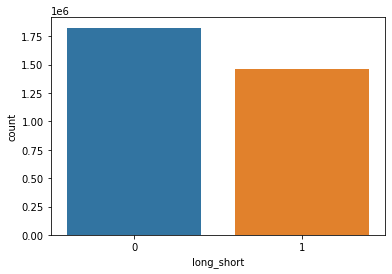

In [ ]:
sns.countplot(x="long_short", data=data)

In [ ]:
X = np.array(data.drop(['long_short'], axis=1) )
# X = data.drop(['long_short'], axis=1) 
y = data['long_short']
jebal=list(data.drop(['long_short'], axis=1).columns)
# del data

In [ ]:
# 샘플링 기법 사용 x
accuracy=[]
recall=[]
f1=[]
precision=[]

# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
a=0
# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train=pd.DataFrame(data=X_train, columns=jebal)
    X_test=pd.DataFrame(data=X_test, columns=jebal)
    y_train=pd.DataFrame(y_train)
    y_test=pd.DataFrame(y_test)
    
    model = ltb.LGBMClassifier()
    model.fit(X_train, y_train)

    # model = LogisticRegression()
    # model.fit(X_train, y_train)

    # model = RandomForestClassifier()
    # model.fit(X_train, y_train)
    
    # model = XGBClassifier()
    # model.fit(X_train, y_train)
    
    recall.append( recall_score(y_test, model.predict(X_test)))
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))
    f1.append(f1_score(y_test, model.predict(X_test)))
    precision.append(precision_score(y_test, model.predict(X_test)))
clear_output()

In [ ]:
# LGBM
print(f'accuracy_score: {np.mean(accuracy):.4f}')
print(f'recall_score: {np.mean(recall):.4f}')
print(f'precision_score: {np.mean(precision):.4f}')
print(f'f1_score: {np.mean(f1):.4f}') 

########################################
# 0초과 롱숏 레이블
# accuracy_score: 0.6267
# recall_score: 0.3697
# precision_score: 0.6411
# f1_score: 0.4689

# 5초과 롱숏 레이블
# accuracy_score: 0.9581
# recall_score: 0.0367
# precision_score: 0.6997
# f1_score: 0.0698
#########################################
#지표 change 넣고 

# 0초과 롱숏 레이블
# accuracy_score: 0.6299
# recall_score: 0.3823
# precision_score: 0.6422
# f1_score: 0.4793


#5초과 롱숏 레이블
# accuracy_score: 0.9581
# recall_score: 0.0355
# precision_score: 0.6982
# f1_score: 0.0675

#################################
# 결측값 처리방식 2

# accuracy_score: 0.6300
# recall_score: 0.3863
# precision_score: 0.6399
# f1_score: 0.4818

####################################
# 새로운 전처리방식

accuracy_score: 0.6072
recall_score: 0.2380
precision_score: 0.6473
f1_score: 0.3480


In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(384, 72))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='#6C8C7D')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# clf = ltb.LGBMClassifier()
# selector = RFECV(clf, cv=5)
# selector = selector.fit(X, y)

## 성능평가(스윙 이진분류)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
# data=data.sort_values('Date') 
# data = data.reset_index(drop=True)
gc.collect()

90

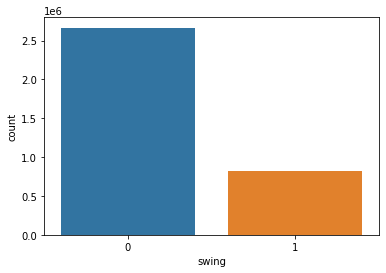

In [ ]:
sns.countplot(x="swing", data=data)

In [ ]:
print(len(data))
# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 컬럼 드랍
data=data.drop(['Date', 'Symbol', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'tomorrow_pred', 'long_short'], axis=1)

# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 

# 100넘는것들 다 100으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)
print(len(data))

3479480
3479050


In [ ]:
X = np.array(data.drop(['swing'], axis=1) )
# X = data.drop(['swing'], axis=1) 
y = data['swing']
jebal=list(data.drop(['swing'], axis=1).columns)
# del data

In [ ]:
# 샘플링 기법 사용 x
accuracy=[]
recall=[]
f1=[]
precision=[]

# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
a=0
# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train=pd.DataFrame(data=X_train, columns=jebal)
    X_test=pd.DataFrame(data=X_test, columns=jebal)
    y_train=pd.DataFrame(y_train)
    y_test=pd.DataFrame(y_test)
    
    model = ltb.LGBMClassifier()
    model.fit(X_train, y_train)

    # model = LogisticRegression()
    # model.fit(X_train, y_train)

    # model = RandomForestClassifier()
    # model.fit(X_train, y_train)
    
    # model = XGBClassifier()
    # model.fit(X_train, y_train)
    
    recall.append( recall_score(y_test, model.predict(X_test)))
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))
    f1.append(f1_score(y_test, model.predict(X_test)))
    precision.append(precision_score(y_test, model.predict(X_test)))
clear_output()

In [ ]:
# LGBM
print(f'accuracy_score: {np.mean(accuracy):.4f}')
print(f'recall_score: {np.mean(recall):.4f}')
print(f'precision_score: {np.mean(precision):.4f}')
print(f'f1_score: {np.mean(f1):.4f}') 

accuracy_score: 0.7779
recall_score: 0.0943
precision_score: 0.6872
f1_score: 0.1658


## 성능평가(회귀)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
data=data.sort_values('Date') 
data = data.reset_index(drop=True)
gc.collect()

22

In [ ]:
# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 컬럼 드랍
data=data.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'long_short'], axis=1)

# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 

# 1000넘는것들 다 1000으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)

In [ ]:
X = np.array(data.drop(['tomorrow_pred'], axis=1) )
y = data['tomorrow_pred']
jebal=list(data.drop(['tomorrow_pred'], axis=1).columns)
# del data

In [ ]:
from sklearn.model_selection import KFold
# 샘플링 기법 사용 x
mse=[]
mae=[]
rmse=[]


# split 개수, 셔플 여부 및 seed 설정
str_kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
a=0
# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train=pd.DataFrame(data=X_train, columns=jebal)
    X_test=pd.DataFrame(data=X_test, columns=jebal)
    y_train=pd.DataFrame(y_train)
    y_test=pd.DataFrame(y_test)
    
    model = ltb.LGBMRegressor()
    model.fit(X_train, y_train)
    
    mae.append( mean_absolute_error(y_test, model.predict(X_test)))
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
    rmse.append(  mean_squared_error(y_test, model.predict(X_test))**0.5 )
clear_output()

In [ ]:
# LGBM
print(f'mae_score: {np.mean(mae):.4f}')
print(f'mse_score: {np.mean(mse):.4f}')
print(f'rmse_score: {np.mean(rmse):.4f}')

mae_score: 0.0182
mse_score: 0.0008
rmse_score: 0.0282


In [ ]:
# 처음
# mae_score: 0.0201
# mse_score: 0.0297
# rmse_score: 0.1622
############################
# 나중

##실전성능평가(이진분류)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
data=data.sort_values('Date') 
data = data.reset_index(drop=True)
# gc.collect()
print(len(data))

In [ ]:
# data.loc[data['Date']=='2020-11-10 00:00:00+09:00',:]
# data.loc[3088382]
# data

In [ ]:
# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)

# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 남겨놓기
data2=data.loc[3088382:,['Date', 'Symbol', 'tomorrow_pred']]
sym=data['Symbol'].tolist()[3088382:]
test_date=data['Date'].tolist()[3088382:]

# 컬럼 드랍
data=data.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'tomorrow_pred'], axis=1)

# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 

# 1000넘는것들 다 1000으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

In [ ]:
# 이분법으로 접근
train=data.loc[:3088382,:]
test=data.loc[3088382:,:]
X_train = train.drop(['long_short'], axis=1) 
y_train = train['long_short'] 
X_test = test.drop(['long_short'], axis=1) 
y_test = test['long_short'] 

In [ ]:
# 2분법으로 예측
import lightgbm as ltb
model = ltb.LGBMClassifier()
model.fit(X_train, y_train)

preds=[]
pre=model.predict_proba(X_test)
for qss in pre:
    preds.append(qss[1]*100)

In [ ]:
print(len(test_date))
print(len(sym))
print(len(preds))

390668
390668
390668


In [ ]:
result = pd.DataFrame({
        "Date":test_date,
        "Symbol": sym,
        "pred": preds
    })

In [ ]:
result['max_pred']=result.groupby("Date")['pred'].transform('max')
dapji=result.loc[(result['pred']==result['max_pred']) & (result['max_pred']>50),['Date','Symbol','pred']]
# dapji=result.loc[(result['pred']==result['max_pred']) ,['Date','Symbol','pred']]
dapji = dapji.reset_index(drop=True)

In [ ]:
# 실제 오른정도 불러오기
for i in range(len(dapji)):
    dapji.loc[i,'actual']=data2.loc[(data2['Date']==dapji['Date'][i]) & (data2['Symbol']==dapji['Symbol'][i]), 'tomorrow_pred'].values*100

In [ ]:
dapji

In [ ]:
dapji['Date']=pd.to_datetime(dapji['Date'])

In [ ]:
자본금=1000000
money=[]
aa=dapji['actual'].tolist()
for i in aa:
    자본금=(자본금*0.99985*((100+i)/100))*0.99985
    money.append(자본금)

dapji['money'] = money
print(f'{자본금:.0f}₩')

511789₩


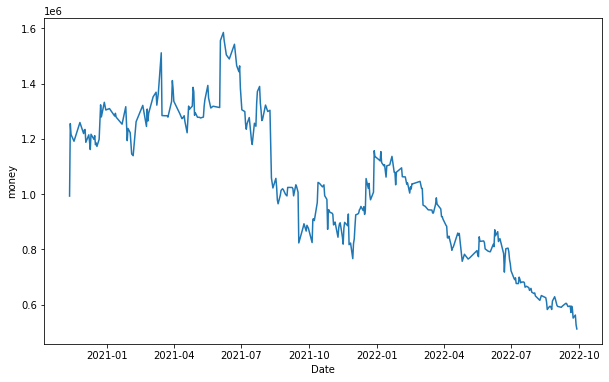

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
fig.set_facecolor('white')
sns.lineplot(data=dapji, x='Date', y='money')
plt.show()

## 실전성능평가(스윙)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
data=data.sort_values('Date') 
data = data.reset_index(drop=True)
# gc.collect()
print(len(data))

3479480


In [ ]:
# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)

# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 남겨놓기
data2=data.loc[3088382:,['Date', 'Symbol', 'highest_high_rate','lowest_low_rate','after20_rate']]
sym=data['Symbol'].tolist()[3088382:]
test_date=data['Date'].tolist()[3088382:]

# 컬럼 드랍
data=data.drop(['Date', 'Symbol','long_short', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'tomorrow_pred'], axis=1)

# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 

# 1000넘는것들 다 1000으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

In [ ]:
# 이분법으로 접근
train=data.loc[:3088382,:]
test=data.loc[3088382:,:]
X_train = train.drop(['swing'], axis=1) 
y_train = train['swing'] 
X_test = test.drop(['swing'], axis=1) 
y_test = test['swing'] 

In [ ]:
# 2분법으로 예측
import lightgbm as ltb
model = ltb.LGBMClassifier()
model.fit(X_train, y_train)

preds=[]
pre=model.predict_proba(X_test)
for qss in pre:
    preds.append(qss[1]*100)

In [ ]:
result = pd.DataFrame({
        "Date":test_date,
        "Symbol": sym,
        "pred": preds
    })

In [ ]:
result['max_pred']=result.groupby("Date")['pred'].transform('max')
dapji=result.loc[(result['pred']==result['max_pred']) & (result['max_pred']>50),['Date','Symbol','pred']]
# dapji=result.loc[(result['pred']==result['max_pred']) ,['Date','Symbol','pred']]

dapji = dapji.reset_index(drop=True)

In [ ]:
# 20일간 최대상승폭 최대하락폭 20일후종가 데이터 불러오기
for i in range(len(dapji)):
    dapji.loc[i,'lowest_low_rate']=data2.loc[(data2['Date']==dapji['Date'][i]) & (data2['Symbol']==dapji['Symbol'][i]), 'lowest_low_rate'].values*100

for i in range(len(dapji)):
    dapji.loc[i,'highest_high_rate']=data2.loc[(data2['Date']==dapji['Date'][i]) & (data2['Symbol']==dapji['Symbol'][i]), 'highest_high_rate'].values*100

for i in range(len(dapji)):
    dapji.loc[i,'after20_rate']=data2.loc[(data2['Date']==dapji['Date'][i]) & (data2['Symbol']==dapji['Symbol'][i]), 'after20_rate'].values*100

In [ ]:
dapji

,Date,Symbol,pred,lowest_low_rate,highest_high_rate,after20_rate
0,2022-01-27 00:00:00+09:00,003070,50.913205,-2.439024,16.531165,12.737127
1,2022-02-03 00:00:00+09:00,007110,52.316546,-7.894737,3.157895,0.526316
2,2022-02-04 00:00:00+09:00,007110,51.333883,-9.793814,1.030928,-4.381443
3,2022-02-07 00:00:00+09:00,007110,52.112043,-8.376963,2.617801,-3.403141
4,2022-02-11 00:00:00+09:00,007110,54.515476,-7.713499,5.234160,-6.060606
5,2022-03-07 00:00:00+09:00,33637L,53.691865,-6.993007,3.729604,0.466200
6,2022-07-07 00:00:00+09:00,298000,53.585918,-7.262570,7.821229,4.748603


In [ ]:
dapji['Date']=pd.to_datetime(dapji['Date'])

자본금=1000000
money=[]
aa=dapji['lowest_low_rate'].tolist()
bb=dapji['highest_high_rate'].tolist()
cc=dapji['after20_rate'].tolist()
for i in range(len(aa)):
    # 손절
    if aa[i]<=-5:
        자본금=(자본금*0.99985*((100-5)/100))*0.99985
        money.append(자본금)
    elif bb[i]>=10:
        자본금=(자본금*0.99985*((100+10)/100))*0.99985
        money.append(자본금)
    else:
        자본금=(자본금*0.99985*((100+cc[i])/100))*0.99985
        money.append(자본금)       
dapji['money'] = money
print(f'{자본금:.0f}₩')

806905₩


In [ ]:
-19

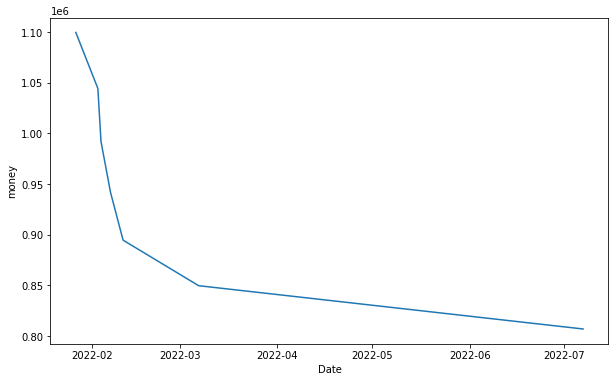

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
fig.set_facecolor('white')
sns.lineplot(data=dapji, x='Date', y='money')
plt.show()

## 실전성능평가(회귀)

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
data=data.sort_values('Date') 
data = data.reset_index(drop=True)
# gc.collect()
print(len(data))


3479480


In [ ]:
data2=data.loc[3088382:,['Date', 'Symbol', 'tomorrow_pred']]
a=data2['Date'].nunique()
b=data2['Symbol'].nunique()
print(a)
print(b)
print(len(data2))
print(a*b)

447
903
391098
403641


In [ ]:
# data.loc[data['Date']=='2020-11-10 00:00:00+09:00',:]
# data.loc[2510683]
# data

In [ ]:
# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)

# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 남겨놓기
data2=data.loc[3088382:,['Date', 'Symbol', 'tomorrow_pred']]
sym=data['Symbol'].tolist()[3088382:]
test_date=data['Date'].tolist()[3088382:]

# 컬럼 드랍
data=data.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'long_short'], axis=1)

# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 

# 100넘는것들 다 100으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

In [ ]:
# 정확한 상승률으로 접근
train=data.loc[:3088382,:]
test=data.loc[3088382:,:]
X_train = train.drop(['tomorrow_pred'], axis=1) 
y_train = train['tomorrow_pred'] 
X_test = test.drop(['tomorrow_pred'], axis=1) 
y_test = test['tomorrow_pred'] 

In [ ]:
# 회귀
import lightgbm as ltb
model = ltb.LGBMRegressor()
model.fit(X_train, y_train)

preds=model.predict(X_test)

preds=preds*100

In [ ]:
result = pd.DataFrame({
        "Date":test_date,
        "Symbol": sym,
        "pred": preds
    })

In [ ]:
result['max_pred']=result.groupby("Date")['pred'].transform('max')
dapji2=result.loc[(result['pred']==result['max_pred']) & (result['max_pred']>1),['Date','Symbol','pred']]
dapji2 = dapji2.reset_index(drop=True)

In [ ]:
# 실제 오른정도 불러오기
for i in range(len(dapji2)):
    dapji2.loc[i,'actual']=data2.loc[(data2['Date']==dapji2['Date'][i]) & (data2['Symbol']==dapji2['Symbol'][i]), 'tomorrow_pred'].values*100

In [ ]:
dapji2

,Date,Symbol,pred,actual
0,2020-11-12 00:00:00+09:00,019175,1.241430,26.484018
1,2020-12-08 00:00:00+09:00,005030,1.066805,-1.973684
2,2020-12-15 00:00:00+09:00,004985,1.138257,-1.568627
3,2020-12-21 00:00:00+09:00,019175,1.312991,-6.400000
4,2020-12-22 00:00:00+09:00,006890,1.017475,-4.195804
5,2020-12-23 00:00:00+09:00,011000,1.987923,5.109491
6,2020-12-24 00:00:00+09:00,092200,1.565356,2.767528
7,2021-01-04 00:00:00+09:00,006110,1.369769,0.803213
8,2021-01-19 00:00:00+09:00,019170,1.080186,3.157895
9,2021-01-27 00:00:00+09:00,024070,1.102282,-4.166667


In [ ]:
자본금=1000000
money=[]
aa=dapji2['actual'].tolist()
for i in aa:
    자본금=(자본금*0.99985*((100+i)/100))*0.99985
    money.append(자본금)

dapji2['money'] = money
print(f'{자본금:.0f}₩')

1473129₩


In [ ]:
dapji2['Date']=pd.to_datetime(dapji2['Date'])

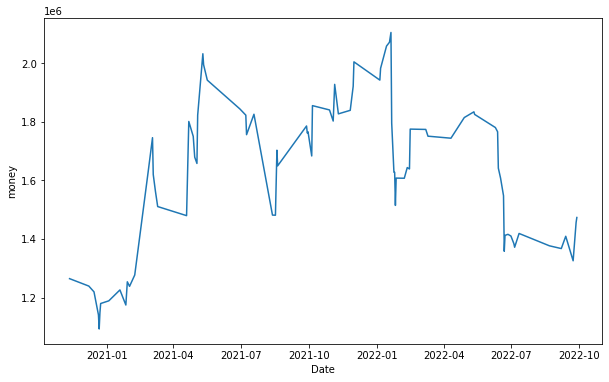

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
fig.set_facecolor('white')
sns.lineplot(data=dapji2, x='Date', y='money')
plt.show()

# 딥러닝

## lstm 학습 데이터셋 만들기

In [3]:
data = pd.read_pickle('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /longshort_7.csv')
data=data.sort_values('Date') 
data = data.reset_index(drop=True)
gc.collect()
print(len(data))

3479480


In [4]:
data=data.drop(['plus_di_updiv',
       'minus_di_updiv', 'adx_updiv', 'RSI_updiv', 'K_updiv', 'D_updiv',
       'MACD_updiv', 'MACDsig_updiv', 'MACDhist_updiv', 'CCI_updiv',
       'MFI_updiv', 'plus_di_downdiv', 'minus_di_downdiv', 'adx_downdiv',
       'RSI_downdiv', 'K_downdiv', 'D_downdiv', 'MACD_downdiv',
       'MACDsig_downdiv', 'MACDhist_downdiv', 'CCI_downdiv',
       'MFI_downdiv','CL=F_plus_di_updiv', 'CL=F_minus_di_updiv', 'CL=F_adx_updiv',
       'CL=F_RSI_updiv', 'CL=F_K_updiv', 'CL=F_D_updiv',
       'CL=F_MACD_updiv', 'CL=F_MACDsig_updiv', 'CL=F_MACDhist_updiv',
       'CL=F_CCI_updiv', 'CL=F_MFI_updiv', 'CL=F_plus_di_downdiv',
       'CL=F_minus_di_downdiv', 'CL=F_adx_downdiv', 'CL=F_RSI_downdiv',
       'CL=F_K_downdiv', 'CL=F_D_downdiv', 'CL=F_MACD_downdiv',
       'CL=F_MACDsig_downdiv', 'CL=F_MACDhist_downdiv',
       'CL=F_CCI_downdiv', 'CL=F_MFI_downdiv','^GSPC_plus_di_updiv',
       '^GSPC_minus_di_updiv', '^GSPC_adx_updiv', '^GSPC_RSI_updiv',
       '^GSPC_K_updiv', '^GSPC_D_updiv', '^GSPC_MACD_updiv',
       '^GSPC_MACDsig_updiv', '^GSPC_MACDhist_updiv', '^GSPC_CCI_updiv',
       '^GSPC_MFI_updiv', '^GSPC_plus_di_downdiv',
       '^GSPC_minus_di_downdiv', '^GSPC_adx_downdiv', '^GSPC_RSI_downdiv',
       '^GSPC_K_downdiv', '^GSPC_D_downdiv', '^GSPC_MACD_downdiv',
       '^GSPC_MACDsig_downdiv', '^GSPC_MACDhist_downdiv',
       '^GSPC_CCI_downdiv', '^GSPC_MFI_downdiv', '^KS11_plus_di_updiv', '^KS11_minus_di_updiv',
       '^KS11_adx_updiv', '^KS11_RSI_updiv', '^KS11_K_updiv',
       '^KS11_D_updiv', '^KS11_MACD_updiv', '^KS11_MACDsig_updiv',
       '^KS11_MACDhist_updiv', '^KS11_CCI_updiv', '^KS11_MFI_updiv',
       '^KS11_plus_di_downdiv', '^KS11_minus_di_downdiv',
       '^KS11_adx_downdiv', '^KS11_RSI_downdiv', '^KS11_K_downdiv',
       '^KS11_D_downdiv', '^KS11_MACD_downdiv', '^KS11_MACDsig_downdiv',
       '^KS11_MACDhist_downdiv', '^KS11_CCI_downdiv', '^KS11_MFI_downdiv' ], axis=1)

In [5]:
# 결측값, inf값 0으로 치환
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

# 변화율이 30을 초과하거나 -30미만인 경우 드랍
data=data.drop(index=data[ data['Close_change'] < -0.3  ].index)
data=data.drop(index=data[ data['Close_change'] > 0.3  ].index)

data = data.reset_index(drop=True)

In [ ]:
# data.loc[data['Date']=='2020-11-10 00:00:00+09:00',:]
# data.loc[3087981]
# data

In [6]:
# 남겨놓기
data2=data.loc[3087981:,['Date', 'Symbol', 'tomorrow_pred']]

In [7]:
# # 컬럼 드랍(정규화를 피하기위해 잠시 드랍한것뿐 나중에 합침)
data3=data.loc[:,['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'long_short','tomorrow_pred']]
data=data.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'long_short','tomorrow_pred'], axis=1)


# 이것들은 제외하고
a=data.columns.values
a=a.tolist()
a.remove('BPS') 
a.remove('PER') 
a.remove('PBR') 
a.remove('EPS') 
a.remove('DIV') 
a.remove('DPS') 


# 100넘는것들 다 1000으로 한정
for i in a:
    data.loc[data[i]>100,i]=100
for i in a:
    data.loc[data[i]<-100,i]=-100

In [8]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
col=data.columns.values
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))

data.columns=col

In [9]:
# 옆으로 합치기 - 열 기준
data=pd.concat([data3, data], axis = 1)

In [10]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
# lstm 데이터셋 만들기
# 날짜에 따른 데이터 분리작업
train=data.loc[:3087981,:]


#lstm데이터셋 만들기 
#only train
nus=train['Symbol'].nunique()
us=train['Symbol'].unique().tolist()
for i in tqdm(range(nus)):
# for i in tqdm(range(1)):
    sb=us[i]
    df=train.loc[train['Symbol']==sb,:]
    df=df.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'long_short'], axis=1)
    # df는 종목 데이터 train_feature와 train_label로 분리한다
    train_feature = df.drop(['tomorrow_pred'], axis=1) 
    train_label = df['tomorrow_pred'] 

    window_size=5
    # train dataset(lstm데이터화 시키기)
    train_feature, train_label = make_dataset(train_feature, train_label, window_size)

    # train, validation set 생성
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
    
    if i==0:
        X_train=x_train
        X_valid=x_valid
        Y_train=y_train
        Y_valid=y_valid
    else:
        X_train=np.concatenate((X_train, x_train))
        X_valid=np.concatenate((X_valid, x_valid))
        Y_train=np.concatenate((Y_train, y_train))
        Y_valid=np.concatenate((Y_valid, y_valid))
    print(X_train.shape, Y_train.shape)

In [18]:
print((X_train.shape))
print((X_valid.shape))
print((Y_train.shape))
print((Y_valid.shape))

(2466603, 5, 181)
(617008, 5, 181)
(2466603,)
(617008,)


In [19]:
# 저장하기 불러오기
np.save('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /X_train.npy',X_train)
np.save('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /X_valid.npy',X_valid)
np.save('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /Y_train.npy',Y_train)
np.save('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /Y_valid.npy',Y_valid)
# np.load('test.npy')

## 모델만들기

In [3]:
X_train=np.load('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /X_train.npy')
X_valid=np.load('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /X_valid.npy')
Y_train=np.load('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /Y_train.npy')
Y_valid=np.load('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 /Y_valid.npy')

In [ ]:
print((X_train.shape))
print((X_valid.shape))
print((Y_train.shape))
print((Y_valid.shape))

In [7]:
# node256layer9
model = Sequential()
model.add(LSTM(256, 
            input_shape=(X_train.shape[1], X_train.shape[2]), 
            return_sequences=False)
        )
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))

In [ ]:
# 훈련
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics =['mse'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 ', 'first.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, Y_train, 
                    epochs=10000, 
                    batch_size=1,
                    validation_data=(X_valid, Y_valid), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# 훈련과정 시각화
# print(history.history)

# # 6 훈련 과정 시각화 (정확도)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # 7 훈련 과정 시각화 (손실)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

##테스트셋 만들기

In [12]:
# node256layer9
model = Sequential()
model.add(LSTM(256, 
            input_shape=(5, 181), 
            return_sequences=False)
        )
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))

In [13]:
# 모델불러오기 로딩
import os
filename = os.path.join('/content/drive/MyDrive/ColabNotebooks/개인프로젝트/비트코인 ', 'first.h5')
model.load_weights(filename)

In [ ]:
# 날짜에 따른 데이터 분리작업
# train=data.loc[:3087981,:]
test=data.loc[3087981:,:] # 이미 정규화 되어있는 상태임


#lstm데이터셋 만들기 
nus=test['Symbol'].nunique()
us=test['Symbol'].unique().tolist()
for i in tqdm(range(nus)):
# for i in tqdm(range(30)):
    window_size=5
    sb=us[i]
    df=test.loc[test['Symbol']==sb,:]
    date=df['Date'][window_size:]
    symbol=df['Symbol'][window_size:]
    df=df.drop(['Date', 'Symbol','swing', 'highest_high_rate', 'lowest_low_rate', 'after20_rate', 'long_short'], axis=1)

    # df는 종목 데이터 train_feature와 train_label로 분리한다
    test_feature = df.drop(['tomorrow_pred'], axis=1) 
    test_label = df['tomorrow_pred'] 

    # train dataset(lstm데이터화 시키기)
    x_test, y_test = make_dataset(test_feature, test_label, window_size)


    # 성능평가 데이터셋 만들기

    # 실전평가 데이터셋 만들기
    preds=model.predict(x_test)

    res = pd.DataFrame({
        "Date":date,
        "Symbol":symbol,
        "pred": preds.flatten().tolist()
    })
    if i==0:
        X_test=x_test
        Y_test=y_test
        result=res
    else:
        X_test=np.concatenate((X_test, x_test))
        Y_test=np.concatenate((Y_test, y_test))
        result=pd.concat([result, res])
        
    print(X_test.shape, Y_test.shape)

In [19]:
print((X_test.shape))
print((Y_test.shape))

(386554, 5, 181)
(386554,)


## 성능평가 & 실전성능평가

성능평가

In [34]:
# score = model.evaluate(X_test, Y_test)
preds=model.predict(X_test)

# print('loss score:', score[0])
# print('accuracy score:', score[1])
print('MAE: ',  mean_absolute_error(Y_test,preds))
print('MSE: ',  mean_squared_error(Y_test,preds))
print('RMSE: ',  mean_squared_error(Y_test,preds)**0.5)

12080/12080 [==============================] - 26s 2ms/step
MAE:  0.017271794408290683
MSE:  0.0007562035868727463
RMSE:  0.027499156112010897


실전성능평가

In [49]:
preds

array([[-0.00193409],
       [-0.00193409],
       [-0.00193409],
       ...,
       [-0.00193409],
       [-0.00193409],
       [-0.00193409]], dtype=float32)

In [44]:
result = result.reset_index(drop=True)
result['max_pred']=result.groupby("Date")['pred'].transform('max')

# dapji=result.loc[(result['pred']==result['max_pred']) & (result['max_pred']>0.01),['Date','Symbol','pred']]
dapji=result.loc[(result['pred']==result['max_pred']) ,['Date','Symbol','pred']]
dapji = dapji.reset_index(drop=True)

In [42]:
# 실제 오른정도 불러오기
for i in range(len(dapji)):
    dapji.loc[i,'actual']=data2.loc[(data2['Date']==dapji['Date'][i]) & (data2['Symbol']==dapji['Symbol'][i]), 'tomorrow_pred'].values*100

In [46]:
result.tail(100)

,Date,Symbol,pred,max_pred
386454,2022-09-21 00:00:00+09:00,011690,-0.001934,-0.001934
386455,2022-09-22 00:00:00+09:00,011690,-0.001934,-0.001934
386456,2022-09-23 00:00:00+09:00,011690,-0.001934,-0.001934
386457,2022-09-26 00:00:00+09:00,011690,-0.001934,-0.001934
386458,2022-09-27 00:00:00+09:00,011690,-0.001934,-0.001934
386459,2022-09-28 00:00:00+09:00,011690,-0.001934,-0.001934
386460,2022-07-22 00:00:00+09:00,329180,-0.001934,-0.001934
386461,2022-07-25 00:00:00+09:00,329180,-0.001934,-0.001934
386462,2022-07-26 00:00:00+09:00,329180,-0.001934,-0.001934
386463,2022-07-27 00:00:00+09:00,329180,-0.001934,-0.001934


In [43]:
dapji

,Date,Symbol,pred


In [37]:
자본금=1000000
money=[]
aa=dapji['actual'].tolist()
for i in aa:
    자본금=(자본금*0.99985*((100+i)/100))*0.99985
    money.append(자본금)

dapji['money'] = money
print(f'{자본금:.0f}₩')

KeyError: ignored

In [ ]:
dapji2['Date']=pd.to_datetime(dapji2['Date'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
fig.set_facecolor('white')
sns.lineplot(data=dapji, x='Date', y='money')
plt.show()